Install all required libraries

In [1]:
!pip install keras
!pip install tensorflow  
!pip3 install opencv-python
!pip install pypng
!pip install matplotlib

from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage import data,filters
from PIL import ImageTk, Image

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Meter_Images/

import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np
import pathlib
import PIL
import os,png,array
import pandas as pd
import time

     |████████████████████████████████| 462 kB 5.1 MB/s 
     |████████████████████████████████| 48 kB 2.3 MB/s 
Mounted at /content/drive
/content/drive/MyDrive/Meter_Images


Load CNN_SVHN ML Model

In [3]:
from keras.models import load_model
classifier=load_model('/content/drive/My Drive/Meter_Images/cnn_svhn_.model')

Predicting meter value from meter images using CNN_SVHN ML Model

RAJA (37).jpg METER READING=000594
RAJA (103).jpg METER READING=00090None
RAJA (21).jpg METER READING=200536
RAJA (3).jpg METER READING=000521
RAJA (131).jpg METER READING=007533
RAJA (78).jpg METER READING=002330
RAJA (46).jpg METER READING=00620None
RAJA (22).jpg METER READING=20016None
RAJA (32).jpg METER READING=00500None
RAJA (104).jpg METER READING=000490
RAJA (65).jpg METER READING=006980
RAJA (5).jpg METER READING=000530
RAJA (107).jpg METER READING=000836
RAJA (121).jpg METER READING=000830
RAJA (34).jpg METER READING=005860
RAJA (31).jpg METER READING=000560
RAJA (113).jpg METER READING=000820
RAJA (28).jpg METER READING=007559
RAJA (29).jpg METER READING=005620
RAJA (99).jpg METER READING=000379
RAJA (106).jpg METER READING=000850
RAJA (17).jpg METER READING=600533
RAJA (74).jpg METER READING=000724
RAJA (68).jpg METER READING=10NoneNoneNoneNone
RAJA (83).jpg METER READING=002380
RAJA (2).jpg METER READING=000521
RAJA (85).jpg METER READING=00500None
RAJA (89).jpg METER READ

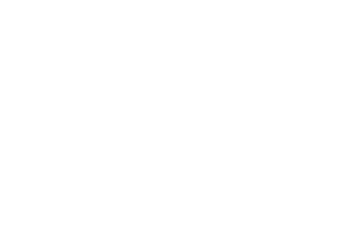

In [4]:
row_list = []
index_counter = 0
resize_counter = 0

directory="/content/drive/My Drive/Meter_Images/"

for file in os.listdir(directory):
  try:

    if file.endswith(".jpg"): 
        img = cv2.imread(file, 0)

        img = cv2.GaussianBlur(img, (3,3), 0)

        def auto_canny(image, sigma=0.33):

            v = np.median(image)
            lower = int(max(0, (1.0 - sigma) * v))
            upper = int(min(255, (1.0 + sigma) * v))
            edged = cv2.Canny(image, lower, upper, apertureSize=3, L2gradient=True)
            return edged

        edges = auto_canny(img)

        contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        contours_dict = dict()
        for cont in contours:
            x, y, w, h = cv2.boundingRect(cont)
            area = cv2.contourArea(cont)
            if 20 < area and 20 < w and h > 10 :
                contours_dict[(x, y, w, h)] = cont

        contours_filtered = sorted(contours_dict.values(), key=cv2.boundingRect)
        blank_background = np.zeros_like(edges)
        img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (255,255,255), thickness=2)

        def is_overlapping_horizontally(box1, box2):
            x1, _, w1, _ = box1
            x2, _, _, _ = box2
            if x1 > x2:
                return is_overlapping_horizontally(box2, box1)
            return (x2 - x1) < w1

        def merge(box1, box2):
            assert is_overlapping_horizontally(box1, box2)
            x1, y1, w1, h1 = box1
            x2, y2, w2, h2 = box2
            x = min(x1, x2)
            w = max(x1 + w1, x2 + w2) - x
            y = min(y1, y2)
            h = max(y1 + h1, y2 + h2) - y
            return (x, y, w, h)

        def windows(contours):
            boxes = []
            for cont in contours:
                box = cv2.boundingRect(cont)
                if not boxes:
                    boxes.append(box)
                else:
                    if is_overlapping_horizontally(boxes[-1], box):
                        last_box = boxes.pop()
                        merged_box = merge(box, last_box)
                        boxes.append(merged_box)
                    else:
                        boxes.append(box)
            return boxes

        boxes = windows(contours_filtered)
        len_boxes = len(boxes)

        for n in range(len_boxes):
          x, y, w, h = boxes[n]
          plt.axis('off')
          
          if y < 10:
              y = 10
          if x < 10:
              x = 10
              
          roi = img[y-10:y+h+5, x-10:x+w+5]
          roi = cv2.resize(roi,(32, 32),interpolation = cv2.INTER_AREA)
          a = str(n+1)
          cv2.imwrite('basamak'+a+'.png', roi)

        columnNames = list()

        for i in range(1024):
            pixel = 'pixel'
            pixel += str(i)
            columnNames.append(pixel)

        train_data = pd.DataFrame(columns = columnNames)

        for n in range(len_boxes):
            a = str(n+1)
            b='basamak'+a+'.png'
            img = Image.open(b)
            rawData = img.load()
            data = []
            for y in range(32):
                for x in range(32):
                    data.append(rawData[x,y])
            k = 0
            train_data.loc[0] = [data[k] for k in range(1024)]
            train_data = train_data.div(255)
            train_data.to_csv("train_converted"+a+".csv",index = False)


        w ={}
        for n in range(len_boxes):
            a = str(n+1)
            b = "train_converted"+a+".csv"
            x_pred = pd.read_csv(b)
            x_pred = x_pred.iloc[:,:].values.astype('float32')
            x_pred =x_pred.reshape(-1, 32, 32, 1)
            predictions=classifier.predict(x_pred)
            x = predictions[4]
            c = "predictions"+a
            w.update( {c : x.argmax()} )
        
        row = [file,  str(w.get("predictions1")) + 
               str(w.get("predictions2")) +  
               str(w.get("predictions3")) +
               str(w.get("predictions4")) +
               str(w.get("predictions5")) +
               str(w.get("predictions6")) ]

        row_list.append(row)

        print( file + " " + "METER READING=" +
            str(w.get("predictions1")) + 
            str(w.get("predictions2")) +  
            str(w.get("predictions3")) +
            str(w.get("predictions4")) +
            str(w.get("predictions5")) +
            str(w.get("predictions6")) 
            )

        continue
        
    else:
        continue

  except IndexError:
    if IndexError:
      index_counter += 1
      print(file + " " +'List index out of range error')
      print('index count: ', index_counter)
      pass

Create a new file "predicted_meter_reading.csv" for new predicted values

In [5]:
with open('predicted_meter_reading.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerows(row_list)
print(len(row_list))

133


Calculating resize counter error and index counter error

In [7]:
print("-------------------------------------")
print("resize counter error:", " ", resize_counter)
print("index counter error:" , " " , index_counter)
print("-------------------------------------")
read = 133 - (int(resize_counter) + int(index_counter))
not_read = int(resize_counter) + int(index_counter)
print("reading: ", read)
print("not reading: ", not_read)
print("-------------------------------------")

-------------------------------------
resize counter error:   0
index counter error:   0
-------------------------------------
reading:  133
not reading:  0
-------------------------------------


Displaying predicted value of the meter

In [8]:
read_value = pd.read_csv("predicted_meter_reading.csv")
read_value.columns = ["imageID", "read_value"]
read_value["imageID"] = read_value["imageID"].str.replace(r'.jpg$', '')
read_value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,imageID,read_value
0,RAJA (103),00090None
1,RAJA (21),200536
2,RAJA (3),000521
3,RAJA (131),007533
4,RAJA (78),002330
...,...,...
127,RAJA (105),00870None
128,RAJA (27),000558
129,RAJA (122),000838
130,RAJA (75),00020None


Displaying actual value of the meter

In [10]:
real_value = pd.read_excel("ACTUAL_METER_VALUE.xlsx", dtype={'actual_value':np.str})
real_value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,imageID,actual_value
0,RAJA (1),000494
1,RAJA (2),000521
2,RAJA (3),000521
3,RAJA (4),000522
4,RAJA (5),000523
...,...,...
128,RAJA (129),000496
129,RAJA (130),000496
130,RAJA (131),000503
131,RAJA (132),000507


Merging actual value and predicted read value for comparision

In [11]:
merged = pd.merge(read_value, real_value, on="imageID")
merged

,imageID,read_value,actual_value
0,RAJA (103),00090None,000795
1,RAJA (21),200536,000539
2,RAJA (3),000521,000521
3,RAJA (131),007533,000503
4,RAJA (78),002330,000733
...,...,...,...
127,RAJA (105),00870None,000800
128,RAJA (27),000558,000558
129,RAJA (122),000838,000838
130,RAJA (75),00020None,000725


Changing "None" to "N" for proper comparision

In [12]:
merged["read_value"] = merged["read_value"].str.replace(r'None', 'N')
merged

,imageID,read_value,actual_value
0,RAJA (103),00090N,000795
1,RAJA (21),200536,000539
2,RAJA (3),000521,000521
3,RAJA (131),007533,000503
4,RAJA (78),002330,000733
...,...,...,...
127,RAJA (105),00870N,000800
128,RAJA (27),000558,000558
129,RAJA (122),000838,000838
130,RAJA (75),00020N,000725


Checking for exact match

In [13]:
merged['IfMatch'] = np.where(merged['read_value'] == merged['actual_value'], 'True', 'False')
merged[merged['IfMatch'] == 'True']

,imageID,read_value,actual_value,IfMatch
2,RAJA (3),000521,000521,True
21,RAJA (74),000724,000724,True
24,RAJA (2),000521,000521,True
48,RAJA (70),000712,000712,True
52,RAJA (123),000839,000839,True
74,RAJA (26),000558,000558,True
88,RAJA (12),000525,000525,True
89,RAJA (6),000523,000523,True
123,RAJA (126),000842,000842,True
128,RAJA (27),000558,000558,True


Finding Accuracy

In [19]:
merged["Total"] = merged['read_value'] 

for row in range(132):

  match_counter = 0

  for basamak in range(6):
    if merged['read_value'][row][basamak]== merged['actual_value'][row][basamak]:
      match_counter += 1

  merged['Total'][row] = match_counter

merged["digit_correctness_of_each_meter"] = (merged["Total"]/6)*100
 
print("accuracy:", (sum (merged["Total"])/ (6*100))*100)

merged

accuracy: 76.83333333333333


,imageID,read_value,actual_value,IfMatch,Total,digit_correctness_of_each_meter
0,RAJA (103),00090N,000795,False,3,50.0
1,RAJA (21),200536,000539,False,4,66.666667
2,RAJA (3),000521,000521,True,6,100.0
3,RAJA (131),007533,000503,False,4,66.666667
4,RAJA (78),002330,000733,False,3,50.0
...,...,...,...,...,...,...
127,RAJA (105),00870N,000800,False,3,50.0
128,RAJA (27),000558,000558,True,6,100.0
129,RAJA (122),000838,000838,True,6,100.0
130,RAJA (75),00020N,000725,False,3,50.0


Plotting Accuracy Curve of the Model

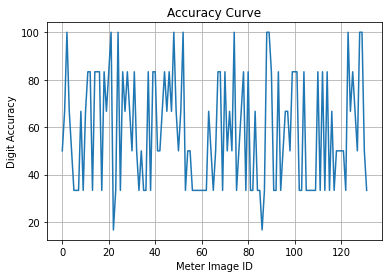

In [25]:
x=list(range(132))
y=merged.digit_correctness_of_each_meter
plt.plot(x,y)
plt.xlabel('Meter Image ID')
plt.ylabel('Digit Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)